# Retinal Blood Vessels Segmentation
### `IABI Course, Dr. Rohban`
#### Homework 1
*`Full Name:`* Amir Mohammad Mehrani Kia

*`SID:`* 402204222

## Proposed Method Description


In this notebook, we aim to extract suitable features using **image processing techniques**,
to obtain a **20-dimensional feature vector** for each pixel. Then, by using a **simple neural network**,
we train the model to learn these features. The goal is for the network to predict, for the **pixels in the test images**,
whether the pixels belong to **vessels** or the **background**.

<p align="left">
<img src="https://drive.usercontent.google.com/download?id=1wpOngGlh_wRui368o22RlfrzPOp7HZKq&export=download&authuser=0&confirm=t&uuid=ccc851a6-589d-47a1-94c5-75343b6e3427&at=AN_67v00Rdv1c_MovmsIyGdovxg6:1727563819162" alt="" width="500"/>
</p>

In [197]:
# !pip install gdown

In [198]:
# ! gdown 1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte
# ! unzip DRIVE

In [1]:
import cv2
import imageio
import numpy as np
import pandas as pd
from os import listdir
import scipy.ndimage as ndi
from typing import *
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from os.path import isfile, join
import skimage.measure
from skimage.morphology import disk
#from google.colab.patches import cv2_imshow
from tqdm import tqdm

In [2]:
def plot_images(images: list[np.ndarray]):
    plt.figure(figsize=(16, 3))
    plt.imshow(
        np.hstack(images), cmap='gray'
    )
    plt.axis('off')
    plt.show()

**DRIVE Dataset Overview:**

In this notebook, the DRIVE dataset has been used, which contains two sets of images: train and test. Each set includes 20 retinal images. For each image, there is a corresponding mask that defines the region of the retina within the image.

The label associated with each image is a binary image where the vessels are represented by the value 255 and the background by the value 0.

Important: Pathological features related to each image are not specified in the dataset.

Note: The labels for the test images are provided by two specialists.

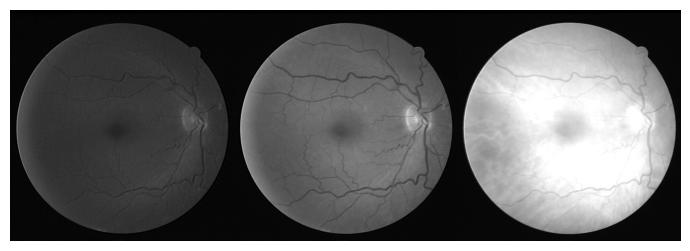

(584, 565)


In [3]:
test_img = cv2.imread('DRIVE/Training/images/22_training.tif')
test_mask = np.array(imageio.mimread('DRIVE/Training/mask/22_training_mask.gif')).reshape(584, 565)

plot_images([test_img[:, :,0 ], test_img[:, :, 1], test_img[:, :, 2]])
print(test_mask.shape)

You must select one of the red, green, or blue channels from the color image `(Explain your reasoning for the selection)`.

`Your response (2 pts):` reason 1 :a blood vessel containing a central light reflex behaves as if there were two separate vessels. In order to eliminate this problem, the morphological opening process is applied on the green channel.
reason 2:Also, in the above photos, it is clear that the details of the blood vessels can be seen more clearly in the green channel.


## Pre-Process (10 pts)

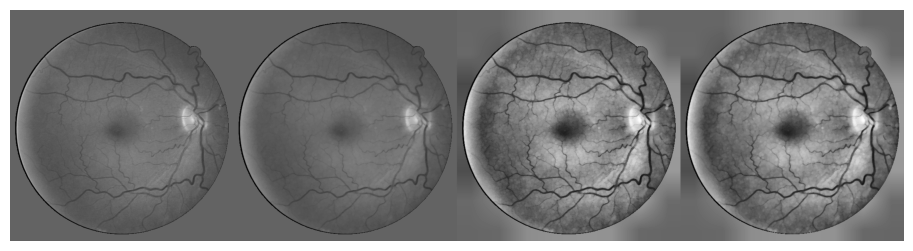

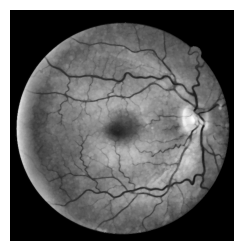

In [4]:
def PreProcess (image: np.ndarray, mask: np.ndarray,plot_image: bool) :
  """
      Args:
          - image (np.ndarray): A 2D  array, shape (height, width).
          - mask (np.ndarray): A binary mask array, shape (height, width).

      Returns:
          - Processed Image (np.ndarray): A 2D array of the same shape as image.

      Steps:
          - Mask Adjustment:
          - Morphological Opening
          - Contrast Enhancement
          - Smoothing
  """
  #################################################################################
  #                         YOUR CODE GOES HERE                                   #
  #first convert mask to binary mask
  # binary_mask = cv2.threshold(mask, 1 , 255 , cv2.THRESH_BINARY ) 
  index = np.where(mask!=0)
  mask[index] = 1
  # plot_image([mask])
  #replace zero masks with mean of the masked image
  masked_image = np.ma.masked_array(image , mask==0)
  mean = masked_image.mean()
  index = np.where(mask==0)
  image[index] = mean
  # mask[:] = 1
  SE = disk(2)
  #now perform steps mentioned in document : you can refer to :
  # https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html
  # https://docs.opencv.org/4.x/d6/db6/classcv_1_1CLAHE.html
  # https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9
  opening = cv2.morphologyEx(image , cv2.MORPH_OPEN , SE) 
  clahe = cv2.createCLAHE(clipLimit=4,tileGridSize=(8,8))
  clh = clahe.apply(opening)
  median = cv2.medianBlur(clh , 3)
  #################################################################################






  if plot_image:
    plot_images([image,opening,clh,median])
  return np.multiply(median, mask)
  # return median


test_img_preprocessed = PreProcess(test_img[:, :, 1], test_mask, plot_image=True)
plot_images([test_img_preprocessed])


## Feature Extraction (70 pts)

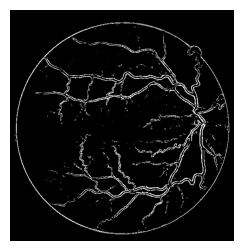

In [5]:
def Roberts_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

    # Roberts Edge Detection: The Roberts operator measures a 2-D spatial gradient on an image in a straightforward, quick-to-compute manner.
    image = image.astype('float64')/255.0
    roberts_cross_v = np.array([[1,0] , [0,-1]])
    roberts_cross_h = np.array( [[ 0 , 1 ] , [ -1 , 0 ]])

    vertical = ndi.convolve(image , roberts_cross_v)
    horizontal = ndi.convolve(image, roberts_cross_h)
    edged_img_sqrt = np.sqrt(np.square(horizontal)+np.square(vertical))
    edged_img = (255 * edged_img_sqrt)
    # print(edged_img)
    threshold = 27  # you can adjust this value
    _, binary_edges = cv2.threshold(edged_img, threshold, 255, cv2.THRESH_BINARY)
    # print(edged_img )
    # edged_img = cv2.threshold(edged_img , 50 , 255 , 255)
    #################################################################################
    return binary_edges
test_edged_img=Roberts_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

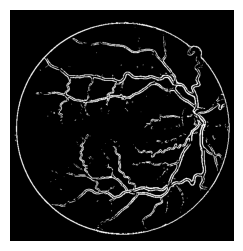

In [6]:
def Prewitt_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

    #Prewitt mask is a first-order derivative mask. In the graph representation of Prewitt-mask’s result, the edge is represented by the local maxima or local minima.
    kernelx = np.array([[1 , 0 , -1] , [1 , 0 , -1] , [1 , 0 ,-1]])
    kernely = np.array([ [ 1 , 1 , 1 ] , [ 0 , 0 , 0] , [-1 , -1 , -1]])
    image = image.astype('float64')/255.0
    img_prewittx = cv2.filter2D(image , -1 , kernelx)
    img_prewitty = cv2.filter2D(image , -1 , kernely)
    edged_img_sqrt = np.sqrt(np.square(img_prewittx)+np.square(img_prewitty))
    edged_img = edged_img_sqrt * 255 
    _, edged_img = cv2.threshold(edged_img, 87, 255, cv2.THRESH_BINARY)
    #################################################################################
    return edged_img
test_edged_img=Prewitt_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

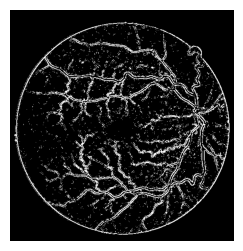

In [24]:
def LOG_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #
    # image = image.astype('float64')/255.0  
    blur = cv2.GaussianBlur(image, (3,3), 0)
    LoG  = cv2.Laplacian(blur , cv2.CV_64F)  
    minLoG = np.zeros_like(LoG)
    maxLoG = np.zeros_like(LoG)
    minLoG[LoG < -6] = 1
    maxLoG[LoG > 6] = 1
    # print(minLoG)
    # LoG = np.uint8(255 * (LoG - minLoG) / (maxLoG - minLoG))
    # print(LoG)
    kernel = np.ones((3, 3), np.uint8)
    minLoG = cv2.morphologyEx(minLoG.astype(np.uint8), cv2.MORPH_DILATE, kernel)
    maxLoG = cv2.morphologyEx(maxLoG.astype(np.uint8), cv2.MORPH_DILATE, kernel)
    zeroCross = minLoG + maxLoG
    # zeroCross[zeroCross > 1] = 0  # Threshold to create a binary image (edges)
    zeroCross = ((LoG > 0) & (minLoG > 0)) | ((LoG < 0) & (maxLoG > 0))
    # z=np.zeros_like(zeroCross)
    # z[zeroCross==0]=255
    # zeroCross=z
    #################################################################################
    return zeroCross
test_edged_img=LOG_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

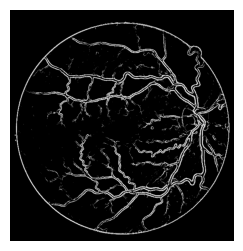

In [206]:
def Edge_Algorithm_features(image):
    """
      Extract edge features from a grayscale image using Roberts, Prewitt and LOG edge detection algorithms.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width)

      Returns:
          np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #
    #Roberts, Prewitt, Sobel, Canny, Log
    R = Roberts_Edge_Detection(image)
    P = Prewitt_Edge_Detection(image)
    s_x=cv2.Sobel(image,cv2.CV_64F,1,0,ksize=3)
    s_y=cv2.Sobel(image,cv2.CV_64F,0,1, ksize=3)
    S = cv2.magnitude(s_x, s_y)
    _, S = cv2.threshold(S, 80, 255, cv2.THRESH_BINARY)
    C = cv2.Canny(image , 70 ,150 )
    L = LOG_Edge_Detection(image)
    #################################################################################
    return R + P + S + C + L
test_edged_img=Edge_Algorithm_features(test_img_preprocessed)
plot_images([test_edged_img])

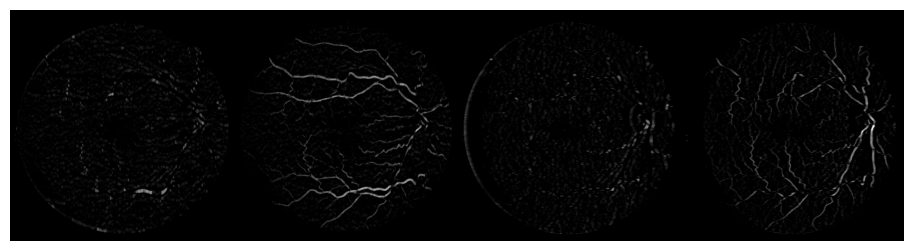

In [207]:
def Morphological_features(image):
    """
      Extract morphological features from a grayscale image using
      top-hat and black-hat morphological transformations.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width).

      Returns:
          tuple: A tuple containing four elements:
              - tophat_img (np.ndarray): The top-hat transformed image, highlighting
                bright features on a dark background.
              - bothat_img (np.ndarray): The black-hat transformed image, emphasizing
                dark features on a bright background.
              - tophat_img2 (np.ndarray): The second top-hat transformed image with
                a different structuring element orientation.
              - bothat_img2 (np.ndarray): The second black-hat transformed image with
                a different structuring element orientation.

    """
    #################################################################################
    #                         YOUR CODE GOES HERE     
    #                               #
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT , (1,11))
    tophat_img = cv2.morphologyEx(image,cv2.MORPH_TOPHAT, kernel)
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT , (6,6))
    bothat_img = cv2.morphologyEx(image,cv2.MORPH_BLACKHAT,kernel)

    ######### new features added #################################
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT , (11,1))
    tophat_img2 = cv2.morphologyEx(image,cv2.MORPH_TOPHAT, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT , (11,1))
    bothat_img2 = cv2.morphologyEx(image,cv2.MORPH_BLACKHAT,kernel)
    #################################################################################
    return tophat_img, bothat_img, tophat_img2, bothat_img2
test_morph_image=Morphological_features(test_img_preprocessed)
plot_images(test_morph_image)


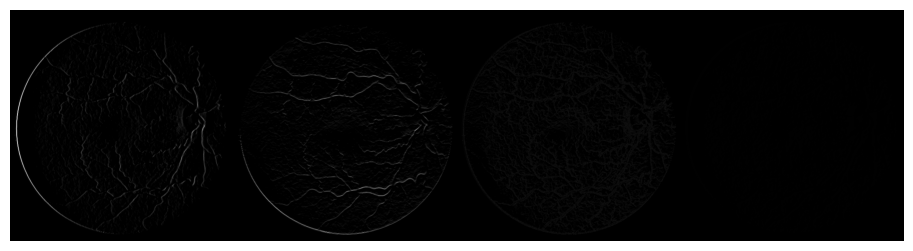

In [208]:
def Gradient_Based_features (image) :
  """
      Calculate gradient-based features from a grayscale image using
      convolution with Sobel-like kernels.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width).


      Returns:
          tuple: A tuple containing four elements:
              - Gx (np.ndarray): The gradient of the image in the x-direction.
              - Gy (np.ndarray): The gradient of the image in the y-direction.
              - M (np.ndarray): The magnitude of the gradient.
              - Theta (np.ndarray): The angle of the gradient direction.
  """
  #################################################################################
  #                         YOUR CODE GOES HERE                                   #
  dx_kernel = np.array([[-1,0,1],
                        [-2,0,2],
                        [-1,0,1]],dtype=np.float32)/4.0
  dy_kernel = np.array([[1,2,1],
                        [0,0,0],
                        [-1,-2,-1]],dtype=np.float32)/4.0

  Gx = cv2.filter2D(src=image,ddepth=-1,kernel=dx_kernel)
  Gy = cv2.filter2D(src=image,ddepth=-1,kernel=dy_kernel)
  M = np.sqrt(Gx**2+Gy**2)
  Theta = np.arctan2(Gx,Gy)

  #################################################################################
  return Gx, Gy, M, Theta
test_gradient_image=Gradient_Based_features(test_img_preprocessed)
plot_images(test_gradient_image)


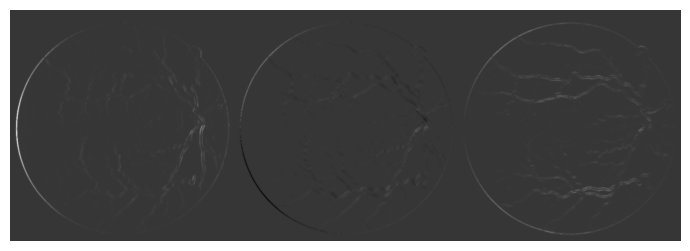

In [209]:
def Hessian_features(image) :
  """
    Calculate Hessian matrix components for a given grayscale image
    to capture second-order derivative information for edge detection.

    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width).

    Returns:
        tuple: A tuple containing three elements:
            - Gxx (np.ndarray): The second derivative of the image with respect
              to the x-direction.
            - Gxy (np.ndarray): The mixed second derivative of the image with respect
              to both x and y directions.
            - Gyy (np.ndarray): The second derivative of the image with respect
              to the y-direction.
  """
  #################################################################################
  #                         YOUR CODE GOES HERE                                   #
  dx_kernel = np.array([[-1,0,1],
                        [-2,0,2],
                        [-1,0,1]],dtype=np.float32)
  dy_kernel = np.array([[1,2,1],
                        [0,0,0],
                        [-1,-2,-1]],dtype=np.float32)
  
  Ix = cv2.Sobel(image, cv2.CV_64F, dx=1 , dy=0, ksize=3)
  Iy = cv2.Sobel(image, cv2.CV_64F, dx=0 , dy=1, ksize=3)
  # Ixy = cv2.Sobel(image,cv2.CV_64F, dx=1 , dy=1, ksize=5)

  Gxx = ndi.gaussian_filter(Ix*Ix,sigma=1)#cv2.filter2D(src=Ix , ddepth=-10,kernel=dx_kernel)
  Gxy = ndi.gaussian_filter(Ix*Iy,sigma=1)
  Gyy = ndi.gaussian_filter(Iy*Iy,sigma=1)
  # Gxx = cv2.GaussianBlur(Gxx, (5,5), 0)
  # Gxy = cv2.GaussianBlur(Gxy, (5,5), 0)
  # Gxy = cv2.GaussianBlur(Gyy, (5,5), 0)
  #################################################################################
  return Gxx, Gxy, Gyy

test_hessian_image=Hessian_features(test_img_preprocessed)
plot_images(test_hessian_image)

In [210]:
def Statistical_features(image, index):
    """
    Compute statistical features from a given grayscale image.

    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width).
        index (tuple(np.ndarray,np.ndarray)): A tuple of two vector which contains x and y coordinates of non-zero pixels
    Returns:
        np.ndarray: A 3D array of shape (height, width, 8) containing the following
                    statistical features for each pixel:
                    - Mean
                    - Minimum
                    - Maximum
                    - Skewness
                    - Kurtosis
                    - Standard Deviation
                    - Mean Absolute Deviation
                    - Root Sum of Squared Levels
    """

    #################################################################################
    #                         YOUR CODE GOES HERE                                   #


    # Mean, Minimum, Maximum, Skewness, Kurtosis, Standard deviation,
    # Mean absolute deviation, Root sum of squared level, size = 21
    k = 10
    # print(image.shape)
    # image = np.pad(image , 5 , mode='constant', constant_values=image.mean())
    # print(image.shape)
    img = cv2.copyMakeBorder(image, k, k, k, k, cv2.BORDER_CONSTANT, None, image.mean())
    # print(img.shape)
    output = np.zeros((image.shape[0], image.shape[1], 8))

    X , Y = index

    for idx in tqdm(range(len(index[0]))):

            i = X[idx] + k
            j = Y[idx] + k
            window = img[i - k:i + k + 1, j - k:j + k + 1]
            output[i-2*k , j-2*k, 0] = np.mean(window) #mean
            output[i-2*k , j-2*k, 1] = np.min(window)
            output[i-2*k , j-2*k, 2] = np.max(window)
            output[i-2*k , j-2*k, 3] = skew(window.flatten())
            output[i-2*k , j-2*k, 4] = kurtosis(window.flatten()) #kurtosis
            output[i-2*k , j-2*k, 5] = np.std(window) #std
            output[i-2*k , j-2*k, 6] = np.mean(np.abs(window-np.mean(window))) #mean absolute deviation
            output[i-2*k , j-2*k, 7] = np.sqrt(np.sum(window**2)) #root sum of squared level

    #################################################################################
    return [stat for stat in output[:, :]]
index = np.where(test_mask != 0)
test_statistic_features=Statistical_features(test_img_preprocessed,index)
mean, min, max, Skewness, Kurtosis, std, mad, sqrt = np.transpose(test_statistic_features, (2, 0, 1))[:]
test_statistic_features=np.stack((mean[index],  min[index],  max[index],  Skewness[index],  Kurtosis[index],  std[index],  mad[index],  sqrt[index]), axis=1)
data = pd.DataFrame()
df = pd.DataFrame(test_statistic_features)
df

100%|██████████| 227686/227686 [05:49<00:00, 650.95it/s]


,0,1,2,3,4,5,6,7
0,79.455782,0.0,139.0,-2.301267,4.642578,22.935945,14.583121,247.729691
1,79.544218,0.0,139.0,-2.325725,4.805459,22.786368,14.473568,247.440902
2,79.614512,0.0,139.0,-2.335677,4.897703,22.692985,14.440208,245.340580
3,79.666667,0.0,139.0,-2.331457,4.912113,22.666367,14.467120,244.415630
4,79.657596,0.0,139.0,-2.319268,4.885009,22.664631,14.502188,243.563133
...,...,...,...,...,...,...,...,...
227681,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
227682,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
227683,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
227684,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000




1. **Setup Paths**: Defines paths for images, masks, and labels from the DRIVE dataset.
   
2. **Load File Lists**: Retrieves and sorts the filenames for images, masks, and labels from the specified directories.

3. **Initialize DataFrame**: Creates an empty DataFrame to store the extracted features from each processed image.

4. **Image Processing Loop**: Iterates over the first 20 images:
   - Reads each image and its corresponding mask and label.
   - Reshapes the mask and label arrays to standard dimensions.
   - Converts label values from 255 to 1 for binary representation.
   - Applies preprocessing to the image using the `PreProcess` function.

5. **Feature Extraction**: Extracts various features from the preprocessed image:
   - Edge features using the `Edge_Algorithm_features` function.
   - Morphological features using the `Morphological_features` function.
   - Statistical features (mean, min, max, skewness, kurtosis, standard deviation, mean absolute deviation, and root sum of squares) using the `Statistical_features` function.
   - Gradient-based features (Gx, Gy, magnitude, and angle) using the `Gradient_Based_features` function.
   - Hessian features using the `Hessian_features` function.

6. **Feature Compilation**: Stacks the extracted features along with the corresponding label and creates a DataFrame from the features.

7. **Data Storage**: Concatenates the newly created DataFrame with the main DataFrame to accumulate all extracted features.

This step prepares the data for  model training.



In [211]:

train_image_path = 'DRIVE/Training/images/'
train_mask_path  = 'DRIVE/Training/mask/'
train_label_path = 'DRIVE/Training/1st_manual/'

test_image_path = 'DRIVE/Test/images/'
test_mask_path  =  'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'
def extract_features(image_path, mask_path, label_path):

        images = [f for f in listdir(image_path) if isfile(join(image_path, f))]
        images.sort()
        masks = [f for f in listdir(mask_path) if isfile(join(mask_path, f))]
        masks.sort()
        labels = [f for f in listdir(label_path) if isfile(join(label_path, f))]
        labels.sort()
        data = pd.DataFrame()
        for i in tqdm(range(len(images))) :
            image = cv2.imread(join(image_path, images[i]))
            mask = np.array(imageio.mimread(join(mask_path, masks[i]))).reshape(584, 565)
            label = np.array(imageio.mimread(join(label_path, labels[i]))).reshape(584, 565)
            label[np.where(label == 255)] = 1
            index = np.where(mask != 0)
            image = PreProcess(image[:, :, 1], mask,False)

            ################# feature extraction######################################

            edges = Edge_Algorithm_features(image)
            (tophat, bothat, tophat2, bothat2) = Morphological_features(image)
            mean, min, max, Skewness, Kurtosis, std, mad, sqrt = np.transpose(Statistical_features(image, index), (2, 0, 1))[:]
            (Gx, Gy, M, Theta) = Gradient_Based_features(image)
            (Gxx, Gxy, Gyy) = Hessian_features(image)
            features = np.stack((edges[index], tophat[index], bothat[index], Gx[index], Gy[index], tophat2[index], bothat2[index],
                                mean[index],  min[index],  max[index],  Skewness[index],  Kurtosis[index],  std[index],  mad[index],  sqrt[index],
                                M[index], Theta[index], Gxx[index], Gxy[index], Gyy[index], label[index]), axis=1)

            df = pd.DataFrame(features)
            data = pd.concat([data, df])
        return data

 

df_train = extract_features(train_image_path, train_mask_path, train_label_path)
df_test = extract_features(test_image_path, test_mask_path, test_label_path)


100%|██████████| 20/20 [2:04:24<00:00, 373.21s/it]


In [5]:
df_train.to_csv("train.csv")
df_test.to_csv("test.csv")



# df_train=pd.DataFrame.from_csv("train.csv")
df_train = pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")

## Training Phase (18 pts)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

- **Note**: Due to the significant differences in the scale of the extracted features, the values should normalize before training the neural network.


In [7]:
sc = StandardScaler()

shuffled = df_train.sample(frac=1)
X_train = sc.fit_transform(shuffled.iloc[:, 1:21])
Y_train = shuffled.iloc[:, -1].astype(int).to_numpy()

X_test = sc.fit_transform(df_test.iloc[:, 1:21])
Y_test = df_test.iloc[:, -1].astype(int).to_numpy()

- **Note**: Since the number of foreground pixels is much smaller than the background pixels, a weighted binary cross-entropy loss is used, with a higher weight assigned to errors in detecting blood vessels.(9pt)

In [27]:

class MyDataset(Dataset):

  def __init__(self,X, Y):

    self.x_train=torch.tensor(X , dtype=torch.float32)
    self.y_train=torch.tensor(Y , dtype=torch.float32)

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]


class Classifier(nn.Module):
   def __init__(self):
      super(Classifier, self).__init__()
      self.fc1 = nn.Linear(20, 32)
      self.fc2 = nn.Linear(32, 32)
      self.fc4 = nn.Linear(32,16)
      self.fc3 = nn.Linear(16,1)
   def forward(self, x):
      x = torch.tanh(self.fc1(x))
      x = torch.tanh(self.fc2(x))
      x = torch.tanh(self.fc4(x))
      return torch.sigmoid(self.fc3(x))

class weighted_binary_cross_entropy(nn.Module):
    def __init__(self):
      super(weighted_binary_cross_entropy, self).__init__()

    def forward(self, output, target, weights=None):
        output = torch.clamp(output,min=1e-8,max=1-1e-8)

        if weights is not None:
            assert len(weights) == 2
            #################################################################################
            #                         YOUR CODE GOES HERE                                   #
            #implement weighted cross entropy loss
            loss = weights[1] * torch.log(output) * target + weights[0] * (1-target)*torch.log(1 - output)
        else:
            loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

        return torch.neg(torch.mean(loss))

In [28]:
#####################################
###### DO NOT CHANGE THIS CELL ######
#####################################

N_EPOCHS = 20
BATCH_SIZE = 128
LR = 1e-2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(MyDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=False)
model = Classifier().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = weighted_binary_cross_entropy()

- After generating the probability of each pixel being part of a blood vessel. A fixed threshold of `0.4` should choose to binarize these values.

In [29]:
# training loop
def train_model(model, train_dataloader, n_epochs, optimizer, criterion, device):
    model.train()
    train_losses = []
    train_accuracies = []
    for epoch in tqdm(range(n_epochs)):
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #
        epoch_loss = 0
        correct=0
        total=0
        for data, target in train_dataloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            output = output.reshape(target.shape)
            loss = criterion(output, target, [1 , 1.2])
            loss.backward()
            optimizer.step()
            predicted = output >= 0.4
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            epoch_loss += loss.item()
        accu=100.0*correct/total
        train_loss = epoch_loss / len(train_loader)
        train_accuracies.append(accu)
        train_losses.append(train_loss)
    #################################################################################
        print('Epoch: {}  Train Loss: {:.4f}  Accuracy: {:.3f}'.format(epoch+1, train_loss, accu))
    return model, train_losses, train_accuracies


In [30]:
trained_model, train_losses, train_accuracies = train_model(model, train_loader, N_EPOCHS, optimizer, criterion, DEVICE)

  5%|▌         | 1/20 [03:58<1:15:25, 238.20s/it]

Epoch: 1  Train Loss: 0.2139  Accuracy: 92.759


 10%|█         | 2/20 [07:56<1:11:30, 238.35s/it]

Epoch: 2  Train Loss: 0.2028  Accuracy: 93.020


 15%|█▌        | 3/20 [11:54<1:07:31, 238.32s/it]

Epoch: 3  Train Loss: 0.1985  Accuracy: 93.181


 20%|██        | 4/20 [15:43<1:02:33, 234.59s/it]

Epoch: 4  Train Loss: 0.1959  Accuracy: 93.263


 25%|██▌       | 5/20 [18:35<52:57, 211.82s/it]  

Epoch: 5  Train Loss: 0.1946  Accuracy: 93.294


 30%|███       | 6/20 [21:27<46:18, 198.48s/it]

Epoch: 6  Train Loss: 0.1938  Accuracy: 93.318


 35%|███▌      | 7/20 [24:33<42:07, 194.44s/it]

Epoch: 7  Train Loss: 0.1932  Accuracy: 93.339


 40%|████      | 8/20 [28:23<41:08, 205.68s/it]

Epoch: 8  Train Loss: 0.1928  Accuracy: 93.353


 45%|████▌     | 9/20 [31:42<37:17, 203.42s/it]

Epoch: 9  Train Loss: 0.1924  Accuracy: 93.365


 50%|█████     | 10/20 [34:52<33:14, 199.42s/it]

Epoch: 10  Train Loss: 0.1921  Accuracy: 93.375


 55%|█████▌    | 11/20 [37:46<28:43, 191.49s/it]

Epoch: 11  Train Loss: 0.1918  Accuracy: 93.381


 60%|██████    | 12/20 [40:53<25:22, 190.31s/it]

Epoch: 12  Train Loss: 0.1916  Accuracy: 93.385


 65%|██████▌   | 13/20 [44:22<22:50, 195.77s/it]

Epoch: 13  Train Loss: 0.1914  Accuracy: 93.393


 70%|███████   | 14/20 [47:25<19:12, 192.04s/it]

Epoch: 14  Train Loss: 0.1912  Accuracy: 93.396


 75%|███████▌  | 15/20 [50:26<15:43, 188.78s/it]

Epoch: 15  Train Loss: 0.1910  Accuracy: 93.403


 80%|████████  | 16/20 [53:37<12:37, 189.50s/it]

Epoch: 16  Train Loss: 0.1908  Accuracy: 93.409


 85%|████████▌ | 17/20 [56:43<09:24, 188.21s/it]

Epoch: 17  Train Loss: 0.1907  Accuracy: 93.414


 90%|█████████ | 18/20 [59:46<06:13, 186.77s/it]

Epoch: 18  Train Loss: 0.1905  Accuracy: 93.418


 95%|█████████▌| 19/20 [1:03:03<03:09, 189.77s/it]

Epoch: 19  Train Loss: 0.1904  Accuracy: 93.421


100%|██████████| 20/20 [1:06:16<00:00, 198.84s/it]

Epoch: 20  Train Loss: 0.1903  Accuracy: 93.426


--------------
In order to `evaluate` the method, three metrics will be used: accuracy, specificity, and sensitivity, each of which is defined as follows:

First, we define the parameters TP, TN, FP, and FN, which will be used to calculate the mentioned metrics.

`TP`: The number of pixels that are part of the vessel, and the method also correctly identifies them as vessels.

`TN`: The number of pixels that belong to the background, and the method also correctly identifies them as background.

`FP`: The number of pixels that belong to the background, but the method incorrectly identifies them as vessels.

`FN`: The number of pixels that are part of the vessel, but the method incorrectly identifies them as background.

With these definitions in place, the three metrics are defined as follows:


$
\text{Sensitivity} = \frac{TP}{TP + FN}
$


$
\text{Specificity} = \frac{TN}{TN + FP}
$


$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$


In [31]:
def evaluation(image, label, mask) :

  TP = TN =  FP = FN = 0
  row, col = image.shape
  for i in range(row):
    for j in range(col):

     # if mask[i, j] != 0:
        p = image[i, j]
        l = label[i, j]
        if p != 0 and l != 0:
          TP +=1
        elif p != 0 and l == 0 :
          FP +=1
        elif p == 0 and l == 0 :
          TN +=1
        elif p == 0 and l != 0 :
          FN +=1

  Sn = TP/(TP + FN)
  Sp = TN/(TN + FP)
  Acc = (TP + TN)/(TP + TN + FP + FN)

  return Sn, Sp, Acc

-----
- `Note`: you must reach at least `70%` sensitivity, `90%` specificity, and `90%` accuracy. (3 pts)


In [32]:
test_image_path = 'DRIVE/Test/images/'
test_mask_path = 'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'

images = [f for f in listdir(test_image_path) if isfile(join(test_image_path, f))]
images.sort()

masks = [f for f in listdir(test_mask_path) if isfile(join(test_mask_path, f))]
masks.sort()

labels = [f for f in listdir(test_label_path) if isfile(join(test_label_path, f))]
labels.sort()

sum = 0
cnt = 0
sn = sp = acc = 0

for i in tqdm(range(len(images))) :
  image = cv2.imread(join(test_image_path, images[i]))
  mask = np.array(imageio.mimread(join(test_mask_path, masks[i]))).reshape(584, 565)
  label = np.array(imageio.mimread(join(test_label_path, labels[i]))).reshape(584, 565)
  label[np.where(label == 255)] = 1
  index = np.where(mask != 0)
  cnt = index[0].shape[0]

  temp = np.zeros((584, 565))
  X = torch.from_numpy(X_test[sum:sum+cnt, :]).to(DEVICE)
  Y = Y_test[sum:sum+cnt]

  out = model(X.float()).reshape(Y.shape) >= 0.4

  x, y = index
  for idx in range(cnt,) :
    m = x[idx]
    n = y[idx]

    if out[idx] == 1:
      temp[m, n] = 255

  sum += cnt

  ########## for removing borders of mask ##############
  border = LOG_Edge_Detection(mask)
  kernel = np.ones((4, 4), np.uint8)
  border = cv2.dilate(border.astype('uint8'), kernel, iterations=1)
  idx = np.where(border != 0)
  temp[idx] = 0

  SN, SP, ACC = evaluation(temp, label, mask)

  sn += SN
  sp += SP
  acc += ACC
  
print(sn/len(images))
print(sp/len(images))
print(acc/len(images))

100%|██████████| 20/20 [10:30<00:00, 31.51s/it]

0.7350188803870323
0.9771776252942402
0.9558472239059277


- Show two sample images along with their ground truth and the model output at the end. (6 pts)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [01:04<00:00, 32.37s/it]


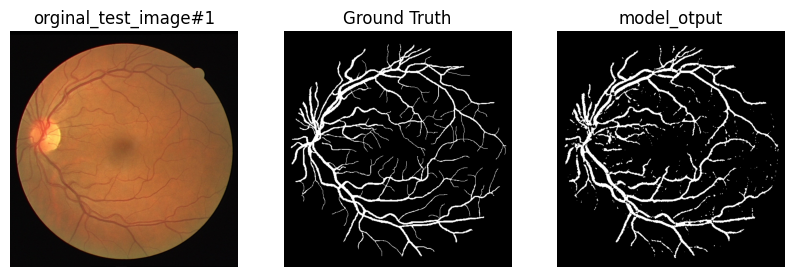

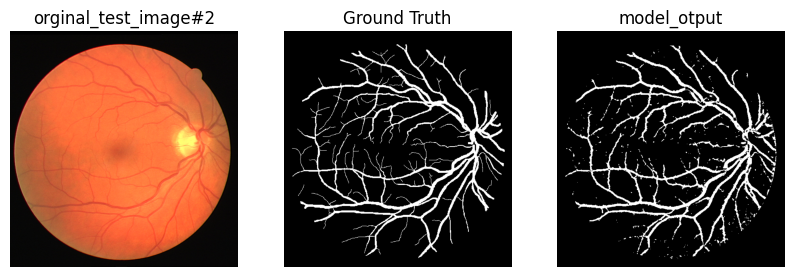

In [33]:
test_image_path = 'DRIVE/Test/images/'
test_mask_path = 'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'
images = [f for f in listdir(test_image_path) if isfile(join(test_image_path, f))]
images.sort()
masks = [f for f in listdir(test_mask_path) if isfile(join(test_mask_path, f))]
masks.sort()
labels = [f for f in listdir(test_label_path) if isfile(join(test_label_path, f))]
labels.sort()
sum = 0
cnt = 0
sn = sp = acc = 0
sample_results = []
for i in tqdm(range(2)):
    image = cv2.imread(join(test_image_path, images[i]))
    mask = np.array(imageio.mimread(join(test_mask_path, masks[i]))).reshape(584, 565)
    label = np.array(imageio.mimread(join(test_label_path, labels[i]))).reshape(584, 565)
    label[np.where(label == 255)] = 1
    index = np.where(mask != 0)
    cnt = index[0].shape[0]
    temp = np.zeros((584, 565))
    X = torch.from_numpy(X_test[sum:sum+cnt, :]).to(DEVICE)
    Y = Y_test[sum:sum+cnt]
    out = model(X.float()).reshape(Y.shape) >= 0.4
    x, y = index
    for idx in range(cnt):
        m = x[idx]
        n = y[idx]
        if out[idx] == 1:
            temp[m, n] = 255
    sum += cnt
    border = LOG_Edge_Detection(mask)
    kernel = np.ones((4, 4), np.uint8)
    border = cv2.dilate(border.astype('uint8'), kernel, iterations=1)
    idx_border = np.where(border != 0)
    temp[idx_border] = 0
    if i < 2:
        sample_results.append({
            'image': image,
            'ground_truth': label * 255,  
            'model_output': temp
        })
for idx, result in enumerate(sample_results):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(result['image'], cv2.COLOR_BGR2RGB))
    plt.title(f'orginal_test_image#{idx+1}')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(result['ground_truth'], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(result['model_output'], cmap='gray')
    plt.title('model_otput')
    plt.axis('off')
    plt.show()